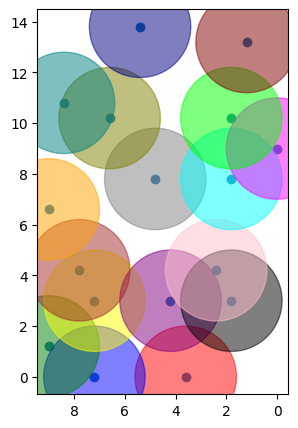

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from src.constants import constants
from src.dataloader import labelDecoding
import pandas as pd
from models.gans_utils import DataAugmentation, get_path_cgan, get_path_wcgan_gp, get_path_wcgan
import tensorflow as tf
from src.dataloader import DataLoader
import warnings
from scipy.stats import entropy
from scipy.linalg import sqrtm
import os
from keras.applications.inception_v3 import InceptionV3
from skimage.transform import resize
 
 

def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return np.asarray(images_list)
 
# calculate frechet inception distance
def calculate_fid(model, images1, images2):
     # calculate activations
     act1 = model.predict(images1)
     act2 = model.predict(images2)
     
     # calculate mean and covariance statistics
     mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
     mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
     
     # calculate sum squared difference between means
     ssdiff = np.sum((mu1 - mu2)**2.0)
     
     # calculate sqrt of product between cov
     covmean = sqrtm(sigma1.dot(sigma2))
     
     # check and correct imaginary numbers from sqrt
     if np.iscomplexobj(covmean):
        covmean = covmean.real
         
     # calculate score
     fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
     return fid
 
# prepare the inception v3 model

def kl_divergence(reals, fakes):
    """
    Esta métrica NO ES SIMÉTRICA

    Estamos midiendo cuanta información estamos perdiendo cuando utilizamos la distribución de fakes (Q) para aproximar la distribución de reals (P)
    """

    # Clip values to avoid division by zero
    reals /= np.sum(reals)
    fakes /= np.sum(fakes)

    reals = np.clip(reals, 1e-10, None)
    fakes = np.clip(fakes, 1e-10, None)

    return entropy(reals.flatten(), fakes.flatten())

def InceptionScore(reals, fake):
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(100,100,3))
    reals = scale_images(reals, (100,100,3))
    fake = scale_images(np.expand_dims(fake, axis=-1), (100,100,3))
    
    # calculate fid
    fid = calculate_fid(model, reals, fake)
    return fid
 

# Obtener las coordenadas del diccionario
plt.figure(figsize=(5, 5))
coords = np.array([y for x, y in constants.labels_dictionary_meters_test.items()])
plt.scatter(coords[:, 0], coords[:, 1])
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_xaxis()

# lista de 23 colores
colors = plt.cm.rainbow(np.linspace(0, 1, 23))

# dibujar un circulo de radio 2 en cada punto
for idx, coord in enumerate(coords):
    circle = plt.Circle(coord, 2, color=constants.colors_test[idx] , alpha=0.5)
    plt.gca().add_artist(circle)
    plt.savefig('example.png')


In [6]:
get_loader = DataLoader(
    data_dir = f"{constants.data.train.FINAL_PATH}/groundtruth.csv",
    aps_list = constants.aps, batch_size = 30, step_size = 5,
    size_reference_point_map = 28, return_axis_coords = False
)

X, y, _ = get_loader()

Interpolando datos con píxel más próximo si son coincidentes


23it [00:36,  1.60s/it]


# Médidas cuantitativas para comprobar la bondad de una gan


1. Average Log-likelihood
2. Coverage Metric
3. Inception Score (IS)
4. Modified Inception Score (m-IS)
5. Mode Score
6. AM Score
7. Frechet Inception Distance (FID)
8. Maximum Mean Discrepancy (MMD)
9. The Wasserstein Critic
10. Birthday Paradox Test
11. Classifier Two-sample Tests (C2ST)
12. Classification Performance
13. Boundary Distortion
14. Number of Statistically-Different Bins (NDB)
15. Image Retrieval Performance
16. Generative Adversarial Metric (GAM)
17. Tournament Win Rate and Skill Rating
18. Normalized Relative Discriminative Score (NRDS)
19. Adversarial Accuracy and Adversarial Divergence
20. Geometry Score
21. Reconstruction Error
22. Image Quality Measures (SSIM, PSNR and Sharpness Difference)
23. Low-level Image Statistics
24. Precision, Recall and F1 Score

# Obtenemos los datos generados por cada GAN

In [4]:

x_cgan, labels = DataAugmentation(path_to_generator=get_path_cgan())(n_samples_per_label = 223)
x_wcgan, _ = DataAugmentation(path_to_generator=get_path_wcgan())(n_samples_per_label = 223)
x_wcgan_gp, _ = DataAugmentation(path_to_generator=get_path_wcgan_gp())(n_samples_per_label = 223)

49/49 [==============================] - 0s 2ms/step


In [ ]:
for x in range(0, 223*7, 223):
    plt.figure(figsize=(20, 10))
    plt.subplot(241)
    plt.imshow(X[x:x+223, :, :, 0].mean(axis=0), cmap="seismic", vmin=0, vmax=1)
    plt.title(f"{constants.aps[int(x/223)]}, Real Mean Image"); plt.gca().invert_xaxis()
    plt.subplot(242)
    plt.imshow(x_cgan[x:x+223].mean(axis=0), cmap="seimic", vmin=0, vmax=1)
    plt.title(f"{constants.aps[int(x/223)]}, CGAN Mean Image"); plt.gca().invert_xaxis()
    plt.subplot(243)
    plt.imshow(x_wcgan[x:x+223].mean(axis=0), cmap="seismic", vmin=0, vmax=1)
    plt.title(f"{constants.aps[int(x/223)]}, WCGAN Mean Image"); plt.gca().invert_xaxis()
    plt.subplot(244)
    plt.imshow(x_wcgan_gp[x:x+223].mean(axis=0), cmap="seismic", vmin=0, vmax=1)
    plt.title(f"{constants.aps[int(x/223)]}, WCGAN-GP Mean Image"); plt.gca().invert_xaxis()
    plt.subplot(245)
    plt.hist(X[x:x+223, :, :, 0].mean(axis=0).ravel(), bins=50, alpha=0.5, label="Real"); plt.title(f"{constants.aps[int(x/223)]}, Real Hist")
    plt.subplot(246)
    plt.hist(x_cgan[x:x+223].mean(axis=0).ravel(), bins=50, alpha=0.5, label="CGAN"); plt.title(f"{constants.aps[int(x/223)]}, CGAN Hist")
    plt.subplot(247)
    plt.hist(x_wcgan[x:x+223].mean(axis=0).ravel(), bins=50, alpha=0.5, label="WCGAN"); plt.title(f"{constants.aps[int(x/223)]}, WCGAN Hist")
    plt.subplot(248)
    plt.hist(x_wcgan_gp[x:x+223].mean(axis=0).ravel(), bins=50, alpha=0.5, label="WCGAN-GP"); plt.title(f"{constants.aps[int(x/223)]}, WCGAN-GP Hist")
    plt.tight_layout()
    plt.show()

In [7]:
labels = labelDecoding(np.arange(0, 7))
for x in range(0, 223*7, 223):
    print("LABEL", labels[int(x/223)])
    print(np.mean(x_cgan[x:x+223].mean(axis=0)) - np.mean(X[0:223, :, :, 0].mean(axis=0)), "distancia Wasserstein CGAN")
    print(np.mean(x_wcgan[x:x+223].mean(axis=0)) - np.mean(X[0:223, :, :, 0].mean(axis=0)), "distancia Wasserstein WCGAN")
    print(np.mean(x_wcgan_gp[x:x+223].mean(axis=0)) - np.mean(X[0:223, :, :, 0].mean(axis=0)), "distancia Wasserstein WCGAN-GP")


# Exportamos a pandas dataframe los resultados
df = pd.DataFrame(columns=["Label", "Model", "Wasserstein Dist"])
for x in range(0, 223*7, 223):
    df = df.append({"Label": labels[int(x/223)], "Model": "CGAN", "Wasserstein Dist": np.mean(x_cgan[x:x+223].mean(axis=0)) - np.mean(X[0:223, :, :, 0].mean(axis=0))}, ignore_index=True)
    df = df.append({"Label": labels[int(x/223)], "Model": "WCGAN", "Wasserstein Dist": np.mean(x_wcgan[x:x+223].mean(axis=0)) - np.mean(X[0:223, :, :, 0].mean(axis=0))}, ignore_index=True)
    df = df.append({"Label": labels[int(x/223)], "Model": "WCGAN-GP", "Wasserstein Dist": np.mean(x_wcgan_gp[x:x+223].mean(axis=0)) - np.mean(X[0:223, :, :, 0].mean(axis=0))}, ignore_index=True)



LABEL GEOTECWIFI03
0.003979568126294408 distancia Wasserstein CGAN
-0.15647032415619155 distancia Wasserstein WCGAN
0.015370373370740209 distancia Wasserstein WCGAN-GP
LABEL 480Invitados
-0.43765157019844314 distancia Wasserstein CGAN
-0.2370227829193141 distancia Wasserstein WCGAN
-0.4493462622736957 distancia Wasserstein WCGAN-GP
LABEL eduroam
0.0895155116344426 distancia Wasserstein CGAN
-0.25841021096458694 distancia Wasserstein WCGAN
0.07325238430747727 distancia Wasserstein WCGAN-GP
LABEL wpen-uji
-0.4658133715962436 distancia Wasserstein CGAN
-0.4996222362493541 distancia Wasserstein WCGAN
-0.4808686555003192 distancia Wasserstein WCGAN-GP
LABEL lt1iot
-0.47196030920496246 distancia Wasserstein CGAN
-0.5049606107746627 distancia Wasserstein WCGAN
-0.47420093720903655 distancia Wasserstein WCGAN-GP
LABEL cuatroochenta
-0.4500650048827197 distancia Wasserstein CGAN
-0.2795975164150264 distancia Wasserstein WCGAN
-0.4531506926392581 distancia Wasserstein WCGAN-GP
LABEL UJI
0.004181

In [205]:
df.groupby(["Model"]).mean()

,Wasserstein Dist
Model,
CGAN,-0.242359
WCGAN,-0.304034
WCGAN-GP,-0.251900


In [8]:
warnings.filterwarnings("ignore")
learning_rates = [0.00005, 0.0001, 0.0005, 0.001, 0.005]
n_critics = [1, 2, 3, 4, 5]
clip_values = [0.001, 0.005, 0.01, 0.05, 0.1]
gradient_penalties = [5, 10, 15]


params_wcgan = {
    "model": "WCGAN",
    "learning_rate": [0.00005, 0.0001, 0.0005, 0.001, 0.005],
    "n_critic": [1, 2, 3, 4, 5],
    "clip_value": [0.001, 0.005, 0.01, 0.05, 0.1]
}

params_wcgan_gp = {
    "model": "WCGAN-GP",
    "learning_rate": [0.00005, 0.0001, 0.0005, 0.001, 0.005],
    "n_critic": [1, 2, 3, 4, 5],
    "gradient_penalty": [5.0, 10.0, 15.0]
}

params_cgan = {
    "model": "CGAN",
    "learning_rate": [0.0005]
}

df = pd.DataFrame(columns=["Model", "Label", "Learning Rate", "N Critic", "Clip Value", "Gradient Penalty", "Wasserstein Dist"])
x_cgan, _ = DataAugmentation(path_to_generator=get_path_cgan(epoch=250))(n_samples_per_label = 223)
for x in range(0, 223*7, 223):
    dist = np.mean(x_cgan[x:x+223].mean(axis=0)) - np.mean(X[x:x+223, :, :, 0].mean(axis=0))
    df.loc[df.shape[0]] = ["CGAN", constants.aps[int(x/223)], params_cgan["learning_rate"][0], np.nan, np.nan, np.nan, dist]
or lr in params_wcgan["learning_rate"]:
    for nc in params_wcgan["n_critic"]:
        for cv in params_wcgan["clip_value"]:
            if os.path.exists(get_path_wcgan(learning_rate=lr, n_critic=nc, clip_value=cv)):
                x_wcgan, _ = DataAugmentation(path_to_generator=get_path_wcgan(learning_rate=lr, n_critic=nc, clip_value=cv))(n_samples_per_label = 223)
                for x in range(0, 223*7, 223):
                    dist = np.mean(x_wcgan[x:x+223].mean(axis=0)) - np.mean(X[x:x+223, :, :, 0].mean(axis=0))
                    df.loc[df.shape[0]] = ["WCGAN", constants.aps[int(x/223)], lr, nc, cv, np.nan, dist]

for lr in params_wcgan_gp["learning_rate"]:
    for nc in params_wcgan_gp["n_critic"]:
        for gp in params_wcgan_gp["gradient_penalty"]:
            if os.path.exists(get_path_wcgan_gp(learning_rate=lr, n_critic=nc, gradient_penalty=gp)):
                x_wcgan_gp, _ = DataAugmentation(path_to_generator=get_path_wcgan_gp(learning_rate=lr, n_critic=nc, gradient_penalty=gp))(n_samples_per_label = 223)
                for x in range(0, 223*7, 223):
                    dist = np.mean(x_wcgan_gp[x:x+223].mean(axis=0)) - np.mean(X[x:x+223, :, :, 0].mean(axis=0))
                    df.loc[df.shape[0]] = ["WCGAN-GP", constants.aps[int(x/223)], lr, nc, np.nan, gp, dist]



SyntaxError: invalid syntax (1743494200.py, line 33)

In [ ]:
df.replace(np.nan, 0).groupby(["Model", "Learning Rate", "N Critic", "Clip Value", "Gradient Penalty"]).mean().reset_index().replace(0, np.nan).sort_values(by="Wasserstein Dist")

In [ ]:
df

In [184]:
# x_preds, _ = DataAugmentation(path_to_generator=get_path_wcgan(0.005, n_critic=2, clip_value=0.005))(n_samples_per_label = 223)
model = tf.keras.models.load_model(get_path_wcgan(0.005, n_critic=2, clip_value=0.005))

In [189]:
generated = model.predict([np.random.normal(0, 1, (7, 100)), np.arange(0, 7).reshape(-1, 1)])


1/1 [==============================] - 0s 15ms/step


In [8]:

warnings.filterwarnings("ignore")





params_wcgan = {
    "model": "WCGAN",
    "learning_rate": [0.00005, 0.0001, 0.0005, 0.001, 0.005],
    "n_critic": [1, 2, 3, 4, 5],
    "clip_value": [0.001, 0.005, 0.01, 0.05, 0.1]
}

params_wcgan_gp = {
    "model": "WCGAN-GP",
    "learning_rate": [0.00005, 0.0001, 0.0005, 0.001, 0.005],
    "n_critic": [1, 2, 3, 4, 5],
    "gradient_penalty": [5.0, 10.0, 15.0]
}

params_cgan = {
    "model": "CGAN",
    "learning_rate": [0.00005, 0.0001, 0.0005, 0.001, 0.005]
}


df = pd.DataFrame(columns=["Model", "Label", "Learning Rate", "N Critic", "Clip Value", "Gradient Penalty", "Kullback-Leibler Divergence"])
x_cgan, _ = DataAugmentation(path_to_generator=get_path_cgan(epoch=250))(n_samples_per_label = 223)
for lr in params_cgan["learning_rate"]:
    if os.path.exists(get_path_cgan(learning_rate=lr)):
        x_cgan, _ = DataAugmentation(path_to_generator=get_path_cgan(learning_rate=lr))(n_samples_per_label = 223)
    for x in range(0, 223*7, 223):
        fake_mean = x_cgan[x:x+223].mean(axis=0)
        real_mean = X[x:x+223, :, :, 0].mean(axis=0)
        dist = kl_divergence(reals=real_mean, fakes=fake_mean)
        df.loc[df.shape[0]] = ["CGAN", constants.aps[int(x/223)], lr, np.nan, np.nan, np.nan, dist]

for lr in params_wcgan["learning_rate"]:
    for nc in params_wcgan["n_critic"]:
        for cv in params_wcgan["clip_value"]:
            if os.path.exists(get_path_wcgan(learning_rate=lr, n_critic=nc, clip_value=cv)):
                x_wcgan, _ = DataAugmentation(path_to_generator=get_path_wcgan(learning_rate=lr, n_critic=nc, clip_value=cv))(n_samples_per_label = 223)
                for x in range(0, 223*7, 223):
                    fake_mean = x_wcgan[x:x+223].mean(axis=0)
                    real_mean = X[x:x+223, :, :, 0].mean(axis=0)
                    dist = kl_divergence(reals=real_mean, fakes=fake_mean)
                    df.loc[df.shape[0]] = ["WCGAN", constants.aps[int(x/223)], lr, nc, cv, np.nan, dist]

for lr in params_wcgan_gp["learning_rate"]:
    for nc in params_wcgan_gp["n_critic"]:
        for gp in params_wcgan_gp["gradient_penalty"]:
            if os.path.exists(get_path_wcgan_gp(learning_rate=lr, n_critic=nc, gradient_penalty=gp)):
                x_wcgan_gp, _ = DataAugmentation(path_to_generator=get_path_wcgan_gp(learning_rate=lr, n_critic=nc, gradient_penalty=gp))(n_samples_per_label = 223)
                for x in range(0, 223*7, 223):
                    fake_mean = x_wcgan_gp[x:x+223].mean(axis=0)
                    real_mean = X[x:x+223, :, :, 0].mean(axis=0)
                    dist = kl_divergence(reals=real_mean, fakes=fake_mean)
                    df.loc[df.shape[0]] = ["WCGAN-GP", constants.aps[int(x/223)], lr, nc, np.nan, gp, dist]



49/49 [==============================] - 0s 2ms/step


In [46]:
df.replace(np.nan, 0).groupby(["Model", "Learning Rate", "N Critic", "Clip Value", "Gradient Penalty"]).mean().reset_index().replace(0, np.nan).sort_values(by="Kullback-Leibler Divergence")

,Model,Learning Rate,N Critic,Clip Value,Gradient Penalty,Kullback-Leibler Divergence
146,WCGAN-GP,0.0001,4.0,NaN,5.0,0.003551
147,WCGAN-GP,0.0001,4.0,NaN,10.0,0.003808
150,WCGAN-GP,0.0001,5.0,NaN,10.0,0.003811
144,WCGAN-GP,0.0001,3.0,NaN,10.0,0.004183
148,WCGAN-GP,0.0001,4.0,NaN,15.0,0.004272
...,...,...,...,...,...,...
122,WCGAN,0.0050,5.0,0.1,NaN,NaN
183,WCGAN-GP,0.0050,1.0,NaN,10.0,NaN
191,WCGAN-GP,0.0050,4.0,NaN,5.0,NaN
193,WCGAN-GP,0.0050,4.0,NaN,15.0,NaN


1/1 [==============================] - 0s 99ms/step


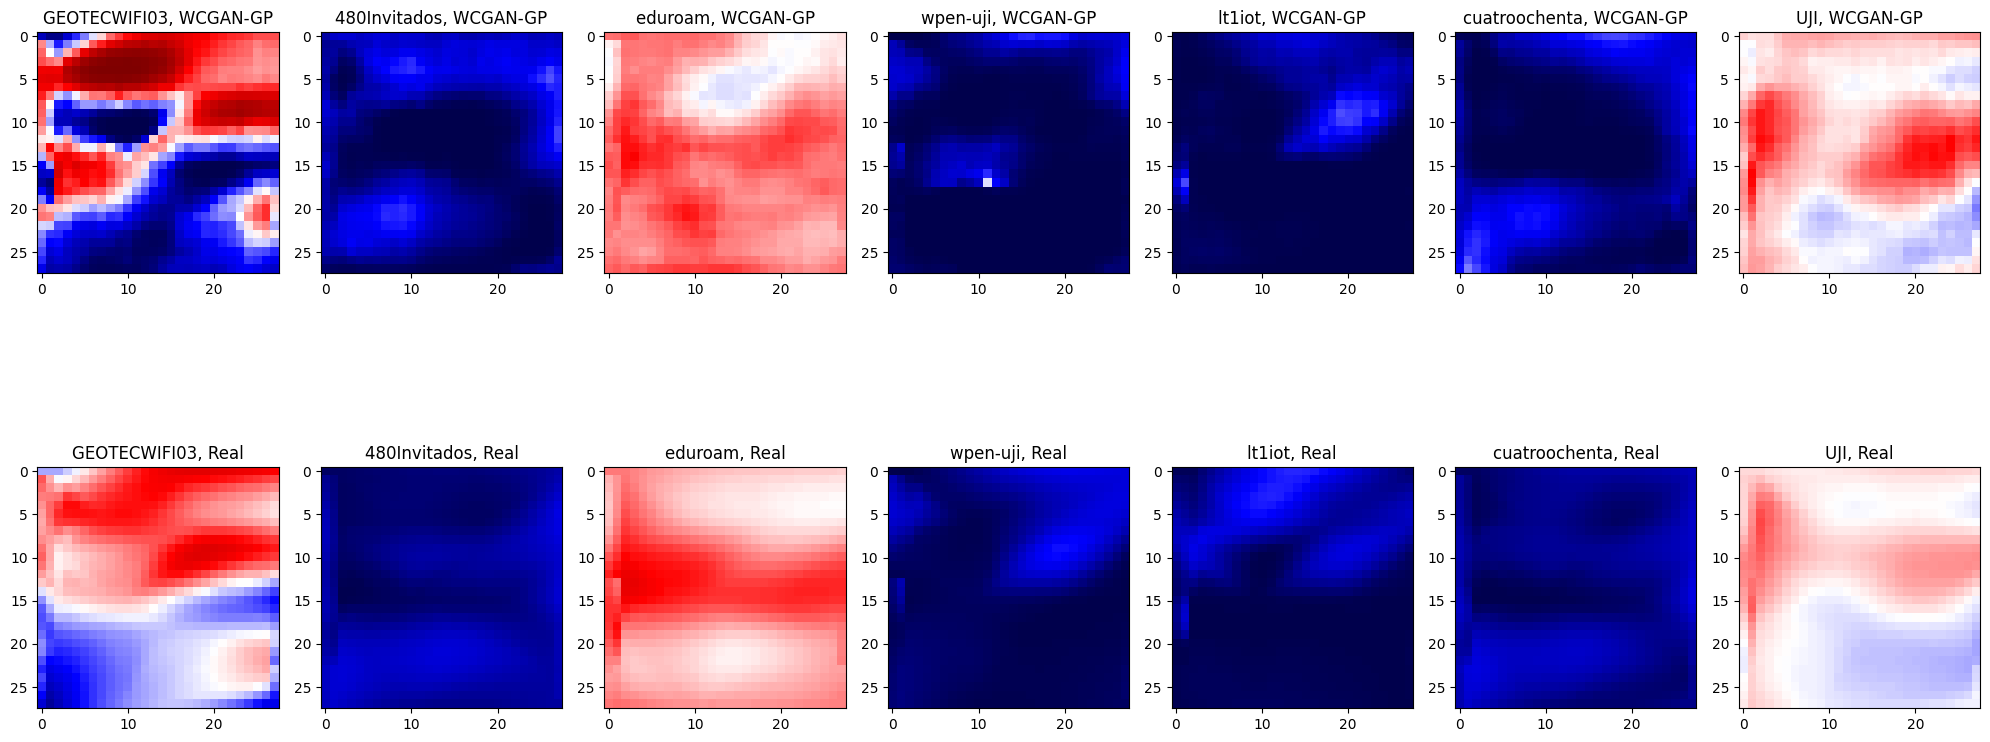

In [15]:
x_preds, _ = DataAugmentation(path_to_generator=get_path_wcgan_gp(learning_rate=0.0001, n_critic=5, gradient_penalty=10.0))(n_samples_per_label = 1)

plt.figure(figsize=(20, 10))
for x in range(0, 7):
    plt.subplot(2, 7, x+1)
    plt.imshow(x_preds[x], cmap="seismic", vmin=0, vmax=1); plt.title(f"{constants.aps[x]}, WCGAN-GP")

for x in range(0, 223*7, 223):
    plt.subplot(2, 7, int(x/223)+8)
    plt.imshow(X[x:x+223, :, :, 0].mean(axis=0), cmap="seismic", vmin=0, vmax=1); plt.title(f"{constants.aps[int(x/223)]}, Real")

plt.tight_layout()
plt.show()

In [9]:
# Media de los 10 mejores modelos agrupados por model
GROUP = df.replace(np.nan, 0).groupby(["Model", "Learning Rate", "N Critic", "Clip Value", "Gradient Penalty"]).mean().reset_index().replace(0, np.nan).sort_values(by="Kullback-Leibler Divergence")

cgan = GROUP[GROUP.Model=="CGAN"].sort_values(by="Kullback-Leibler Divergence").head(3).groupby("Model").mean()["Kullback-Leibler Divergence"]
wcgan = GROUP[GROUP.Model=="WCGAN"].sort_values(by="Kullback-Leibler Divergence").head(3).groupby("Model").mean()["Kullback-Leibler Divergence"]
wcgan_gp = GROUP[GROUP.Model=="WCGAN-GP"].sort_values(by="Kullback-Leibler Divergence").head(3).groupby("Model").mean()["Kullback-Leibler Divergence"]

In [10]:
# media errores top 3 de cada modelo
pd.concat([cgan, wcgan, wcgan_gp])

Model
CGAN        0.015313
WCGAN       0.020716
WCGAN-GP    0.003597
Name: Kullback-Leibler Divergence, dtype: float64

In [14]:
cgan = GROUP[GROUP.Model=="CGAN"].sort_values(by="Kullback-Leibler Divergence").head(1).groupby("Model").mean()["Kullback-Leibler Divergence"]
wcgan = GROUP[GROUP.Model=="WCGAN"].sort_values(by="Kullback-Leibler Divergence").head(1).groupby("Model").mean()["Kullback-Leibler Divergence"]
wcgan_gp = GROUP[GROUP.Model=="WCGAN-GP"].sort_values(by="Kullback-Leibler Divergence").head(1).groupby("Model").mean()["Kullback-Leibler Divergence"]

In [15]:
# best error de cada modelo
pd.concat([cgan, wcgan, wcgan_gp])

Model
CGAN        0.007567
WCGAN       0.012993
WCGAN-GP    0.003336
Name: Kullback-Leibler Divergence, dtype: float64

In [31]:
# clear_output
from IPython.display import clear_output
# example of calculating the frechet inception distance in Keras

# scale an array of images to a new size

warnings.filterwarnings("ignore")


params_wcgan = {
    "model": "WCGAN",
    "learning_rate": [0.00005, 0.0001, 0.0005, 0.001, 0.005],
    "n_critic": [1, 2, 3, 4, 5],
    "clip_value": [0.001, 0.005, 0.01, 0.05, 0.1]
}

params_wcgan_gp = {
    "model": "WCGAN-GP",
    "learning_rate": [0.00005, 0.0001, 0.0005, 0.001, 0.005],
    "n_critic": [1, 2, 3, 4, 5],
    "gradient_penalty": [5.0, 10.0, 15.0]
}

params_cgan = {
    "model": "CGAN",
    "learning_rate": [0.00005, 0.0001, 0.0005, 0.001, 0.005]
}

count = 0
n_total = len(params_wcgan_gp["learning_rate"]) * len(params_wcgan_gp["n_critic"]) * len(params_wcgan_gp["gradient_penalty"]) * len(constants.aps) + \
          len(params_wcgan["learning_rate"]) * len(params_wcgan["n_critic"]) * len(params_wcgan["clip_value"]) * len(constants.aps) + \
          len(params_cgan["learning_rate"]) * len(constants.aps)
df = pd.DataFrame(columns=["Model", "Label", "Learning Rate", "N Critic", "Clip Value", "Gradient Penalty", "Kullback-Leibler Divergence", "Inception Score"])
x_cgan, _ = DataAugmentation(path_to_generator=get_path_cgan(epoch=250))(n_samples_per_label = 223)
for lr in params_cgan["learning_rate"]:
    if os.path.exists(get_path_cgan(learning_rate=lr)):
        x_cgan, _ = DataAugmentation(path_to_generator=get_path_cgan(learning_rate=lr))(n_samples_per_label = 223)
    for x in range(0, 223*7, 223):
        count += 1
        fake_mean = x_cgan[x:x+223].mean(axis=0)
        real_mean = X[x:x+223, :, :, 0].mean(axis=0)
        kl_div = kl_divergence(reals=real_mean, fakes=fake_mean)
        in_score = InceptionScore(reals=X[x:x+223, :, :, 0], fake=x_cgan[x:x+223])
        df.loc[df.shape[0]] = ["CGAN", constants.aps[int(x/223)], lr, np.nan, np.nan, np.nan, kl_div, in_score]
        print("CGAN", "PROGRESS", count, "/", n_total, "INCEPTION", in_score)
        if count % 10 == 0:
            clear_output()
            
for lr in params_wcgan["learning_rate"]:
    for nc in params_wcgan["n_critic"]:
        for cv in params_wcgan["clip_value"]:
            if os.path.exists(get_path_wcgan(learning_rate=lr, n_critic=nc, clip_value=cv)):
                x_wcgan, _ = DataAugmentation(path_to_generator=get_path_wcgan(learning_rate=lr, n_critic=nc, clip_value=cv))(n_samples_per_label = 223)
                for x in range(0, 223*7, 223):
                    count += 1
                    fake_mean = x_wcgan[x:x+223].mean(axis=0)
                    real_mean = X[x:x+223, :, :, 0].mean(axis=0)
                    kl_div = kl_divergence(reals=real_mean, fakes=fake_mean)
                    in_score = InceptionScore(reals=X[x:x+223, :, :, 0], fake=x_wcgan[x:x+223])
                    df.loc[df.shape[0]] = ["WCGAN", constants.aps[int(x/223)], lr, nc, cv, np.nan, kl_div, in_score]
                    print("WCGAN", "PROGRESS", count, "/", n_total, "INCEPTION", in_score)
                    if count % 10 == 0:
                        clear_output()
for lr in params_wcgan_gp["learning_rate"]:
    for nc in params_wcgan_gp["n_critic"]:
        for gp in params_wcgan_gp["gradient_penalty"]:
            if os.path.exists(get_path_wcgan_gp(learning_rate=lr, n_critic=nc, gradient_penalty=gp)):
                x_wcgan_gp, _ = DataAugmentation(path_to_generator=get_path_wcgan_gp(learning_rate=lr, n_critic=nc, gradient_penalty=gp))(n_samples_per_label = 223)
                for x in range(0, 223*7, 223):
                    count += 1
                    print("WCGAN_GP", "PROGRESS", count, "/", n_total)
                    fake_mean = x_wcgan_gp[x:x+223].mean(axis=0)
                    real_mean = X[x:x+223, :, :, 0].mean(axis=0)
                    kl_div = kl_divergence(reals=real_mean, fakes=fake_mean)
                    in_score = InceptionScore(reals=X[x:x+223, :, :, 0], fake=x_wcgan_gp[x:x+223])
                    df.loc[df.shape[0]] = ["WCGAN-GP", constants.aps[int(x/223)], lr, nc, np.nan, gp, kl_div, in_score]
                    print("WCGAN_GP", "PROGRESS", count, "/", n_total, "INCEPTION", in_score)
                    if count % 10 == 0:
                        clear_output()


WCGAN_GP PROGRESS 1421 / 1435
7/7 [==============================] - 0s 15ms/step
WCGAN_GP PROGRESS 1421 / 1435 INCEPTION 923.1960116244859


In [47]:
df.shape

(1421, 8)

In [46]:
df.to_csv("metrics.csv", index=False)

In [48]:
df.replace(np.nan, 0).groupby(["Model","Learning Rate","N Critic","Clip Value","Gradient Penalty"]).mean().reset_index().replace(0, np.nan).sort_values(by="Inception Score")

,Model,Learning Rate,N Critic,Clip Value,Gradient Penalty,Kullback-Leibler Divergence,Inception Score
159,WCGAN-GP,0.00050,1.0,NaN,10.0,0.005802,234.249890
160,WCGAN-GP,0.00050,1.0,NaN,15.0,0.007594,239.370245
173,WCGAN-GP,0.00100,1.0,NaN,5.0,0.010856,246.482048
174,WCGAN-GP,0.00100,1.0,NaN,10.0,0.009263,249.807540
163,WCGAN-GP,0.00050,2.0,NaN,15.0,0.012374,254.393244
...,...,...,...,...,...,...,...
44,WCGAN,0.00010,3.0,0.100,NaN,1.396120,1395.966280
23,WCGAN,0.00005,4.0,0.050,NaN,0.301759,1424.803055
11,WCGAN,0.00005,2.0,0.005,NaN,0.247025,1427.777734
58,WCGAN,0.00050,1.0,0.050,NaN,0.656106,1591.958644


In [40]:
# Media de los 3 mejores modelos agrupados por model

GROUP = df.replace(np.nan, 0).groupby(["Model","Learning Rate","N Critic","Clip Value","Gradient Penalty"]).mean().reset_index().replace(0, np.nan).sort_values(by="Inception Score")

cgan = (GROUP[GROUP.Model=="CGAN"].sort_values(by="Inception Score")
        .head(3)).groupby("Model").mean()[[ "Kullback-Leibler Divergence","Inception Score"]]
wcgan = GROUP[GROUP.Model=="WCGAN"].sort_values(by="Inception Score") \
        .head(3).groupby("Model").mean()[[ "Kullback-Leibler Divergence","Inception Score"]]
wcgan_gp = GROUP[GROUP.Model=="WCGAN-GP"].sort_values(by="Inception Score") \
        .head(3).groupby("Model").mean()[["Kullback-Leibler Divergence", "Inception Score"]]


In [41]:
pd.concat([cgan, wcgan, wcgan_gp])

,Kullback-Leibler Divergence,Inception Score
Model,,
CGAN,0.051320,366.557132
WCGAN,0.025447,362.420611
WCGAN-GP,0.008084,240.034061


In [44]:
# Media del mejor error de cada modelo
cgan = GROUP[GROUP.Model=="CGAN"].sort_values(by="Inception Score") \
        .head(1)

wcgan = GROUP[GROUP.Model=="WCGAN"].sort_values(by="Inception Score") \
        .head(1)

wcgan_gp = GROUP[GROUP.Model=="WCGAN-GP"].sort_values(by="Inception Score") \
        .head(1)

In [45]:
pd.concat([cgan, wcgan, wcgan_gp])

,Model,Learning Rate,N Critic,Clip Value,Gradient Penalty,Kullback-Leibler Divergence,Inception Score
2,CGAN,0.0005,NaN,NaN,NaN,0.018445,298.808914
59,WCGAN,0.0005,1.0,0.1,NaN,0.013507,298.203306
159,WCGAN-GP,0.0005,1.0,NaN,10.0,0.005802,234.249890


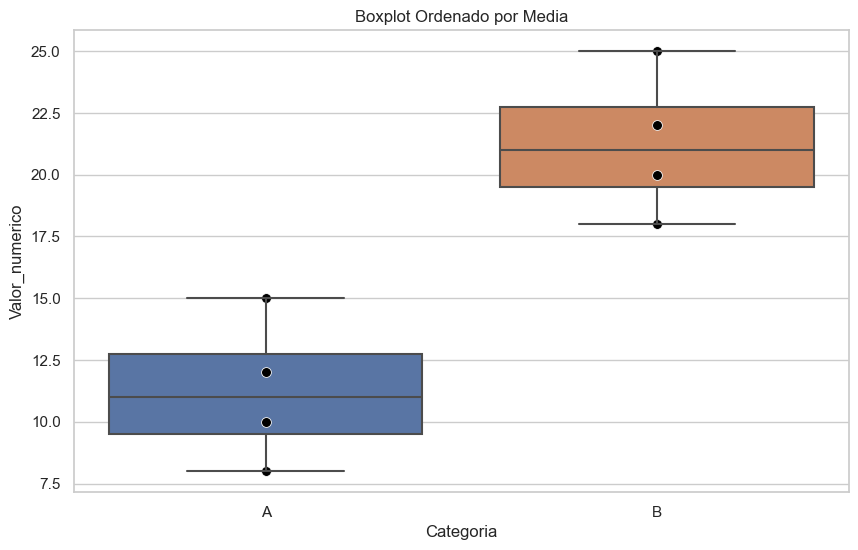

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

ejemplo = pd.DataFrame({
    "Model":["SinRPMAP-KNN", "SinRPMAP-RF", "SinRPMAP-KNN", "SinRPMAP-RF", "SinRPMAP-KNN", 
             "SinRPMAP-RF", "SinRPMAP-KNN", "SinRPMAP-RF", "SinRPMAP-KNN", "SinRPMAP-RF" ],
    "N_REP": [x for x in range(10)],
    "Mean_Euclid_Distance": np.random.normal(0, 1, 10)
})
data = {
    'Categoria': ['A', 'A', 'B', 'B', 'A', 'B', 'A', 'B'],
    'Valor_numerico': [10, 15, 20, 25, 12, 18, 8, 22]
}


df = pd.DataFrame(data)

# Calcular la media por cada categoría
media_por_categoria = df.groupby('Categoria')['Valor_numerico'].mean().sort_values()

# Ordenar el DataFrame original según la media
df_sorted = df.set_index('Categoria').loc[media_por_categoria.index].reset_index()

# Configuración del estilo
sns.set(style="whitegrid")

# Crear el boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Categoria', y='Valor_numerico', data=df_sorted, order=media_por_categoria.index)
sns.scatterplot(x='Categoria', y='Valor_numerico', data=df_sorted, color='black', s=50)
# Mostrar el gráfico
plt.title('Boxplot Ordenado por Media')
plt.show()


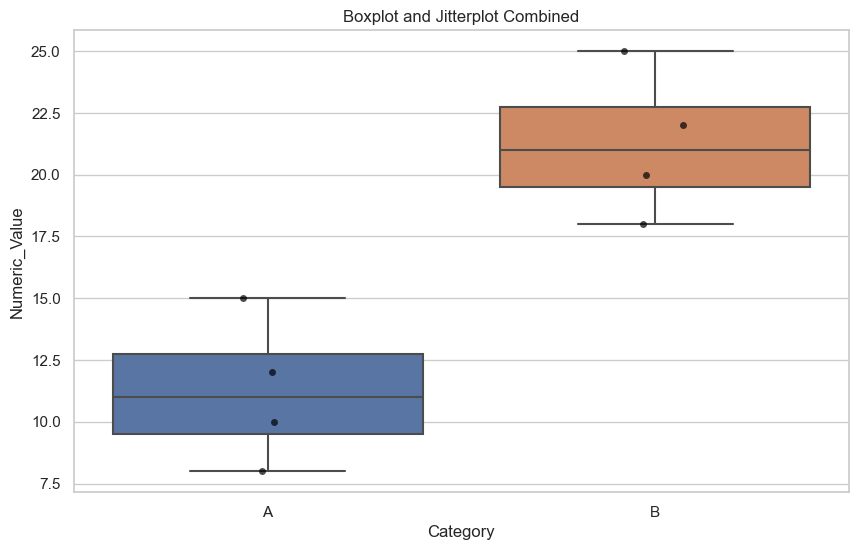

In [19]:
models = pd.DataFrame(columns=["Model", "n_repeat", "Mean_Euclidean_Dist", "RMSE", "MSE", "MAE"])



In [21]:
import pandas as pd
import numpy as np
from src.constants import constants
df = pd.read_csv("outputs/generative_metrics/generative_metrics.csv")
ORDER_METRIC = "Kullback-Leibler Divergence"
# Mean by model
GROUP = df.replace(np.nan, 0).groupby(["Model", "Learning Rate", "N Critic", "Clip Value", "Gradient Penalty"]).mean().reset_index().replace(0, np.nan)

pd.concat([GROUP[GROUP.Model=="CGAN"].sort_values(by=ORDER_METRIC).head(1),
            GROUP[GROUP.Model=="WCGAN"].sort_values(by=ORDER_METRIC).head(1),
            GROUP[GROUP.Model=="WCGAN-GP"].sort_values(by=ORDER_METRIC).head(1)])

C:\Users\javie\AppData\Local\Temp\ipykernel_13320\3551331480.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  GROUP = df.replace(np.nan, 0).groupby(["Model", "Learning Rate", "N Critic", "Clip Value", "Gradient Penalty"]).mean().reset_index().replace(0, np.nan)


,Model,Learning Rate,N Critic,Clip Value,Gradient Penalty,Kullback-Leibler Divergence,Inception Score
3,CGAN,0.0010,NaN,NaN,NaN,0.007567,1120.574275
59,WCGAN,0.0005,1.0,0.1,NaN,0.013507,298.203306
157,WCGAN-GP,0.0001,5.0,NaN,15.0,0.003919,308.338001


In [2]:
import pingouin as pg
import pandas as pd
resultados = pd.read_csv("outputs/positioning_metrics/orderedByKullback/metrics/metrics.csv")

pg.ttest(resultados[resultados.Model=="RPMAP-KNN"]["Mean_Euclidean_Dist"],
         resultados[resultados.Model=="WcGAN (DA)-KNN"]["Mean_Euclidean_Dist"])


C:\Users\javie\miniconda3\lib\site-packages\pingouin\parametric.py:266: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  tval, pval = ttest_ind(x, y, equal_var=True, alternative=alternative)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.450762,18,two-sided,0.657544,"[-0.04, 0.07]",0.201587,0.427,0.071157


In [17]:
import numpy as np
def get_euclid_per_coord(ytrue, ypred):
    euclidean_distances = np.sqrt(np.sum((ypred - ytrue) ** 2, axis=1))
    coords_unique = np.array(list(constants.labels_dictionary_meters_test.values()))
    dist_max, dist_mean, dist_std = [], [], []
    for coord in coords_unique:
        indices = np.where(np.all(ytrue == coord, axis=1))[0]
        if indices.size > 0:
            start, end = indices[0], indices[-1] + 1
            dist_max.append(np.max(euclidean_distances[start:end]))
            dist_mean.append(np.mean(euclidean_distances[start:end]))
            dist_std.append(np.std(euclidean_distances[start:end]))
    return np.array(dist_max), np.array(dist_mean), np.array(dist_std)


ytrue = np.array([(y[0],y[1]) for x,y in constants.labels_dictionary_meters_test.items()])
ypred = np.array([(x,y) for x,y in zip(np.random.normal(0, 1, 17), np.random.normal(0, 1, 17))])

a, b, c = get_euclid_per_coord(ytrue, ypred)

In [18]:
print(a)

[ 4.62368292  7.50842446  8.15219489  9.07160959  5.99898164  3.5211356
  6.39416265  7.90251806 10.99078369  9.04036844  6.91158209  9.15954157
 10.34172135 12.47725446 14.77397371 15.10248857 12.99447055]


In [20]:
metrics = pd.read_csv("outputs/positioning_metrics_per_coord/orderedByKullback/metrics/metrics.csv")

In [71]:
metrics[metrics.Model=="cGAN (DA)-KNN"]["Mean_Euclidean_Dist"].quantile(0.75) 

6.312108892792303

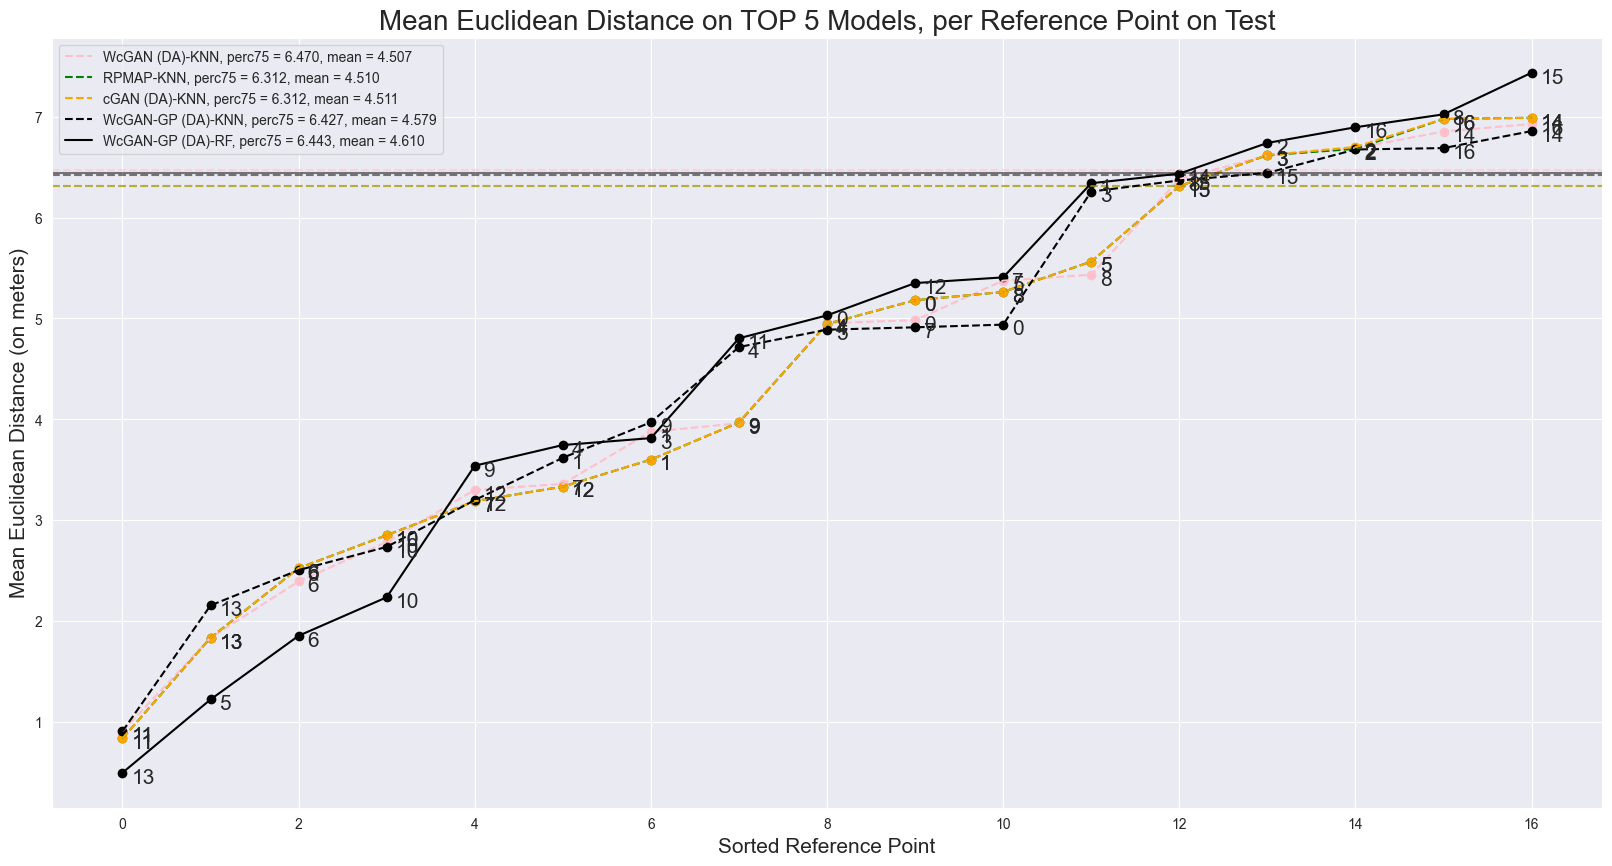

In [114]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))

# top 5 best models based on mean euclidean distance
top_5 = metrics.groupby(["Model"]).mean().reset_index().sort_values(by="Mean_Euclidean_Dist").head(5)["Model"].values

for model in top_5:
    subset = metrics[metrics.Model==model]
    mean_subset = subset["Mean_Euclidean_Dist"].mean()
    perc_75 = np.percentile(subset["Mean_Euclidean_Dist"], 75)
    ordered = subset.groupby(["Model", "id_coord"]).mean().reset_index().sort_values(by="Mean_Euclidean_Dist").drop(["Model", "n_repeat"], axis=1)
    
    plt.scatter([x for x in range(ordered.shape[0])], ordered["Mean_Euclidean_Dist"], color=colors_models[model], alpha=1)
    plt.plot([x for x in range(ordered.shape[0])], ordered["Mean_Euclidean_Dist"], linestyle=dict_linestyles[model], color=colors_models[model], label=f"{model}, perc75 = {perc_75:.3f}, mean = {mean_subset:.3f}", alpha=1)
    plt.axhline(y=perc_75, color=colors_models[model], linestyle=dict_linestyles[model], alpha=0.5)
    # annotate points per id_coord
    for x, y, id_coord in zip([x for x in range(ordered.shape[0])], ordered["Mean_Euclidean_Dist"], ordered["id_coord"]):
        plt.annotate(id_coord, (x+0.1, y-0.1), fontsize=15)
    plt.legend()
    plt.title("Mean Euclidean Distance on TOP 5 Models, per Reference Point on Test", size=20)
    plt.xlabel("Sorted Reference Point", size=15)
    plt.ylabel("Mean Euclidean Distance (on meters)", size=15)